In [1]:
%load_ext Cython

In [185]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --annotate

import numpy as np
cimport numpy as np
cimport cython
#from cython.parallel cimport prange


@cython.boundscheck(False) # won't check that index is in bounds of array
@cython.wraparound(False) # array[-1] won't work
@cython.nonecheck(False) # variables are never set to None
@cython.cdivision(True) # don't protect against dividing by zero
def mcmatrix(np.ndarray[np.float32_t, ndim=3] lmap,np.ndarray[np.float32_t, ndim=2] modlmap, \
             np.ndarray[np.float32_t, ndim=1] bin_edges, \
             np.ndarray[np.complex128_t, ndim=2] kmask2d, np.ndarray[np.float32_t, ndim=1] ly, \
             np.ndarray[np.float32_t, ndim=1] lx):
    cdef:
        int Nb = bin_edges.shape[0]-1
        double sum = 0.
        Mbb = np.zeros((Nb,Nb)) 
        
        double dly = np.diff(ly)[0]
        double dlx = np.diff(lx)[0]
        int i
        int j
        int k
        int l
        
    for i in xrange(Nb):
        for j in xrange(i,Nb):
            leftb = bin_edges[i]
            rightb = bin_edges[i+1]
            lmapb = lmap[:,np.logical_and(modlmap>=leftb,modlmap<rightb)]
            
            leftbp = bin_edges[j]
            rightbp = bin_edges[j+1]
            lmapbp = lmap[:,np.logical_and(modlmap>=leftbp,modlmap<rightbp)]
            
            sum = 0.
            for k in xrange(lmapb.shape[1]):
                for l in xrange(lmapbp.shape[1]):
                    diffl = lmapb[:,k] - lmapbp[:,l]
                    y = np.where(np.isclose(ly,diffl[0],atol=dly/2.))
                    x = np.where(np.isclose(lx,diffl[1],atol=dlx/2.))
                    f = kmask2d[y,x]
                    sum += (f.real**2.+f.imag**2.) 
                    
            Mbb[i,j] = sum
            Mbb[j,i] = sum
    return Mbb


(60, 60)


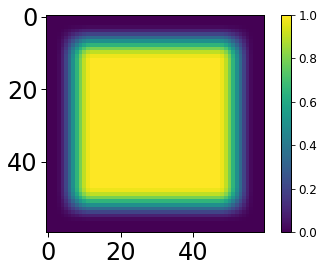

/home/msyriac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


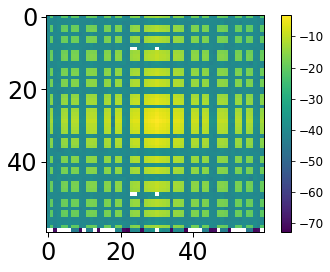

In [179]:
from orphics import maps
from enlib import enmap
shape,wcs = maps.rect_geometry(width_deg=3.,height_deg=3.,px_res_arcmin=3.0)
bin_edges = np.arange(100,1000,100).astype(np.float32)
print(shape)
taper,w2 = maps.get_taper_deg(shape,wcs,taper_width_degrees = 0.5,pad_width_degrees = 0.1,weight=None)
modlmap = enmap.modlmap(shape,wcs)
modrmap = enmap.modrmap(shape,wcs)
#sigma = 1.*np.pi/180.
#taper = np.exp(-modrmap**2./2./sigma**2.) #*0.+1.
io.plot_img(taper)
fc = maps.FourierCalc(shape,wcs)
mp2d,kmask2d,kmask2d = fc.power2d(taper)
kmask2d *= np.sqrt(fc.normfact)
io.plot_img(np.fft.fftshift(np.log10(mp2d)))
lmap = enmap.lmap(shape,wcs)
laxes = enmap.laxes(shape,wcs)
ly = laxes[0]
lx = laxes[1]

In [186]:
%%time
Mbb = mcmatrix(lmap.astype(np.float32),modlmap.astype(np.float32), \
               bin_edges.astype(np.float32),kmask2d,ly.astype(np.float32),lx.astype(np.float32))

CPU times: user 1.77 s, sys: 2.98 ms, total: 1.77 s
Wall time: 1.77 s


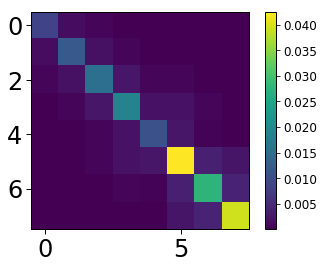

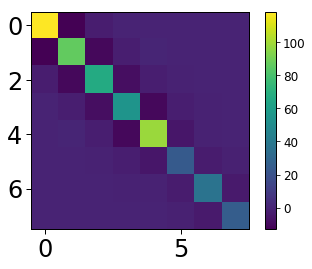

In [184]:
from orphics import io
io.plot_img(Mbb,flip=False)
Mbbinv = np.linalg.inv(Mbb)
io.plot_img(Mbbinv,flip=False)
